# Application of Machine Learning Methods to Analysis of Cyber-Sport Events
## Dmitry Savostyanov, 131

#### Цель: Оценить вклад игрока в победу команды, выявить нетривиальные факторы победы.

#### Задача: Построить интерпретируемую модель предсказания результатов матчей на основе данных по игрокам одной роли среди ТОП-30 лучших команд по версии GGnet http://www.gosugamers.net/dota2/rankings

## Query for https://www.opendota.com/explorer

## Возвращает данные по матчам игрока Resolut1on (carry)

SELECT

matches.match_id,

((player_matches.player_slot < 128) = matches.radiant_win) win,

player_matches.hero_id,

player_matches.account_id,

player_matches.kills,

player_matches.deaths,

player_matches.assists,

player_matches.last_hits,

player_matches.denies,

player_matches.gold_per_min,

player_matches.xp_per_min,

player_matches.gold_spent,

player_matches.hero_damage,

player_matches.tower_damage,

player_matches.hero_healing,

player_matches.level,

player_matches.stuns

-- leagues.name leaguename

FROM matches

JOIN match_patch

USING (match_id)

JOIN leagues

USING(leagueid)

JOIN player_matches

USING(match_id)

LEFT JOIN notable_players

USING(account_id)

LEFT JOIN teams

USING(team_id)

JOIN heroes

ON player_matches.hero_id = heroes.id

WHERE TRUE

AND account_id = 86725175

ORDER BY matches.match_id DESC

NULLS LAST

LIMIT 100000

### SEMMA используется в качестве методологии анализа
The phases of SEMMA and related tasks are the following:

Sample. The process starts with data sampling, e.g., selecting the data set for modeling. The data set should be large enough to contain sufficient information to retrieve, yet small enough to be used efficiently. This phase also deals with data partitioning.

Explore. This phase covers the understanding of the data by discovering anticipated and unanticipated relationships between the variables, and also abnormalities, with the help of data visualization.

Modify. The Modify phase contains methods to select, create and transform variables in preparation for data modeling.

Model. In the Model phase the focus is on applying various modeling (data mining) techniques on the prepared variables in order to create models that possibly provide the desired outcome.

Assess. The last phase is Assess. The evaluation of the modeling results shows the reliability and usefulness of the created models.

In [1]:
import math 
import pandas as pd 
import numpy as np 
import sklearn 
import matplotlib.pyplot as plt 
from sklearn import svm, datasets 
%matplotlib inline

## Sample

In [2]:
JsonAsString = ''
with open('Resoulut1on_all_matches.json') as data_file:
    for line in data_file:
        JsonAsString += line

In [4]:
df = pd.read_json(JsonAsString)

In [5]:
df.head()

account_id  assists  deaths  denies  gold_per_min  gold_spent  hero_damage  \
0    86725175       12       4      15           576     26320.0      25069.0   
1    86725175        7       6      11           612     27150.0      22004.0   
2    86725175        4       5      14           354     14410.0       6666.0   
3    86725175        9       3       6           508     14070.0      13178.0   
4    86725175       14       1      13           587     11570.0      16589.0   

   hero_healing  hero_id  kills  last_hits  level    match_id     stuns  \
0           0.0       93      7        381     25  3017353522  29.66760   
1           0.0       48      4        434     24  3017221173  18.82730   
2           0.0       20      1        180     19  2994783634  12.44340   
3           0.0       80      2        247     21  2994731712   9.15308   
4           0.0       48      5        176     19  2992561442  18.51700   

   tower_damage    win  xp_per_min  
0        2427.0  False         526  
1        7792.0  False         528  
2        1560.0  False         389  
3        4383.0  False         519  
4        5108.0   True         658

In [6]:
df.tail()

account_id  assists  deaths  denies  gold_per_min  gold_spent  \
914    86725175       13       2      17           480         NaN   
915    86725175       16       6       7           340         NaN   
916    86725175       21       3      26           505         NaN   
917    86725175       15       2       9           372         NaN   
918    86725175        4       5      17           383         NaN   

     hero_damage  hero_healing  hero_id  kills  last_hits  level   match_id  \
914          NaN           NaN       21      7        243     21  410760421   
915          NaN           NaN       65      4        211     19  410677311   
916          NaN           NaN       13      7        235     23  409593309   
917          NaN           NaN       13      2        120     18  400510598   
918          NaN           NaN       47      6        161     17  399520020   

     stuns  tower_damage    win  xp_per_min  
914    NaN           NaN   True         492  
915    NaN           NaN  False         366  
916    NaN           NaN   True         650  
917    NaN           NaN   True         457  
918    NaN           NaN  False         477

## Explore

In [7]:
print df.columns.values

[u'account_id' u'assists' u'deaths' u'denies' u'gold_per_min' u'gold_spent'
 u'hero_damage' u'hero_healing' u'hero_id' u'kills' u'last_hits' u'level'
 u'match_id' u'stuns' u'tower_damage' u'win' u'xp_per_min']


In [8]:
ID = ['match_id', 'account_id', 'hero_id']
Target = [u'win']
# categorical = ['level']
numeric = [u'assists', u'deaths', u'denies', u'gold_per_min', u'gold_spent',
           u'hero_damage', u'hero_healing', u'kills', u'last_hits', u'level',
           u'stuns', u'tower_damage', u'win', u'xp_per_min']

In [10]:
df[numeric].describe()

assists      deaths      denies  gold_per_min    gold_spent  \
count  919.000000  919.000000  919.000000    919.000000    495.000000   
mean     9.401523    3.635473   12.732318    534.678999  17809.050505   
std      5.467157    2.794892    7.755253    129.479553   7399.021027   
min      0.000000    0.000000    0.000000     78.000000   1900.000000   
25%      5.000000    1.000000    7.000000    446.000000           NaN   
50%      9.000000    3.000000   12.000000    529.000000           NaN   
75%     13.000000    5.500000   17.000000    619.500000           NaN   
max     36.000000   16.000000   59.000000   1019.000000  49350.000000   

        hero_damage  hero_healing       kills   last_hits       level  \
count    495.000000    495.000000  919.000000  919.000000  919.000000   
mean   13555.408081    173.690909    7.280740  232.059848   18.809576   
std     8403.437439    425.336665    4.613796  118.281493    3.987682   
min     1204.000000      0.000000    0.000000   34.000000    7.000000   
25%             NaN           NaN    4.000000  150.000000   16.000000   
50%             NaN           NaN    7.000000  212.000000   19.000000   
75%             NaN           NaN   10.000000  289.000000   22.000000   
max    74501.000000   2589.000000   30.000000  870.000000   25.000000   

            stuns  tower_damage  xp_per_min  
count  468.000000    495.000000  919.000000  
mean    15.367084   2929.804040  536.377584  
std     26.034271   3090.345193  120.040008  
min     -0.000024      0.000000   79.000000  
25%           NaN           NaN  453.500000  
50%           NaN           NaN  537.000000  
75%           NaN           NaN  615.500000  
max    258.789000  18862.000000  922.000000

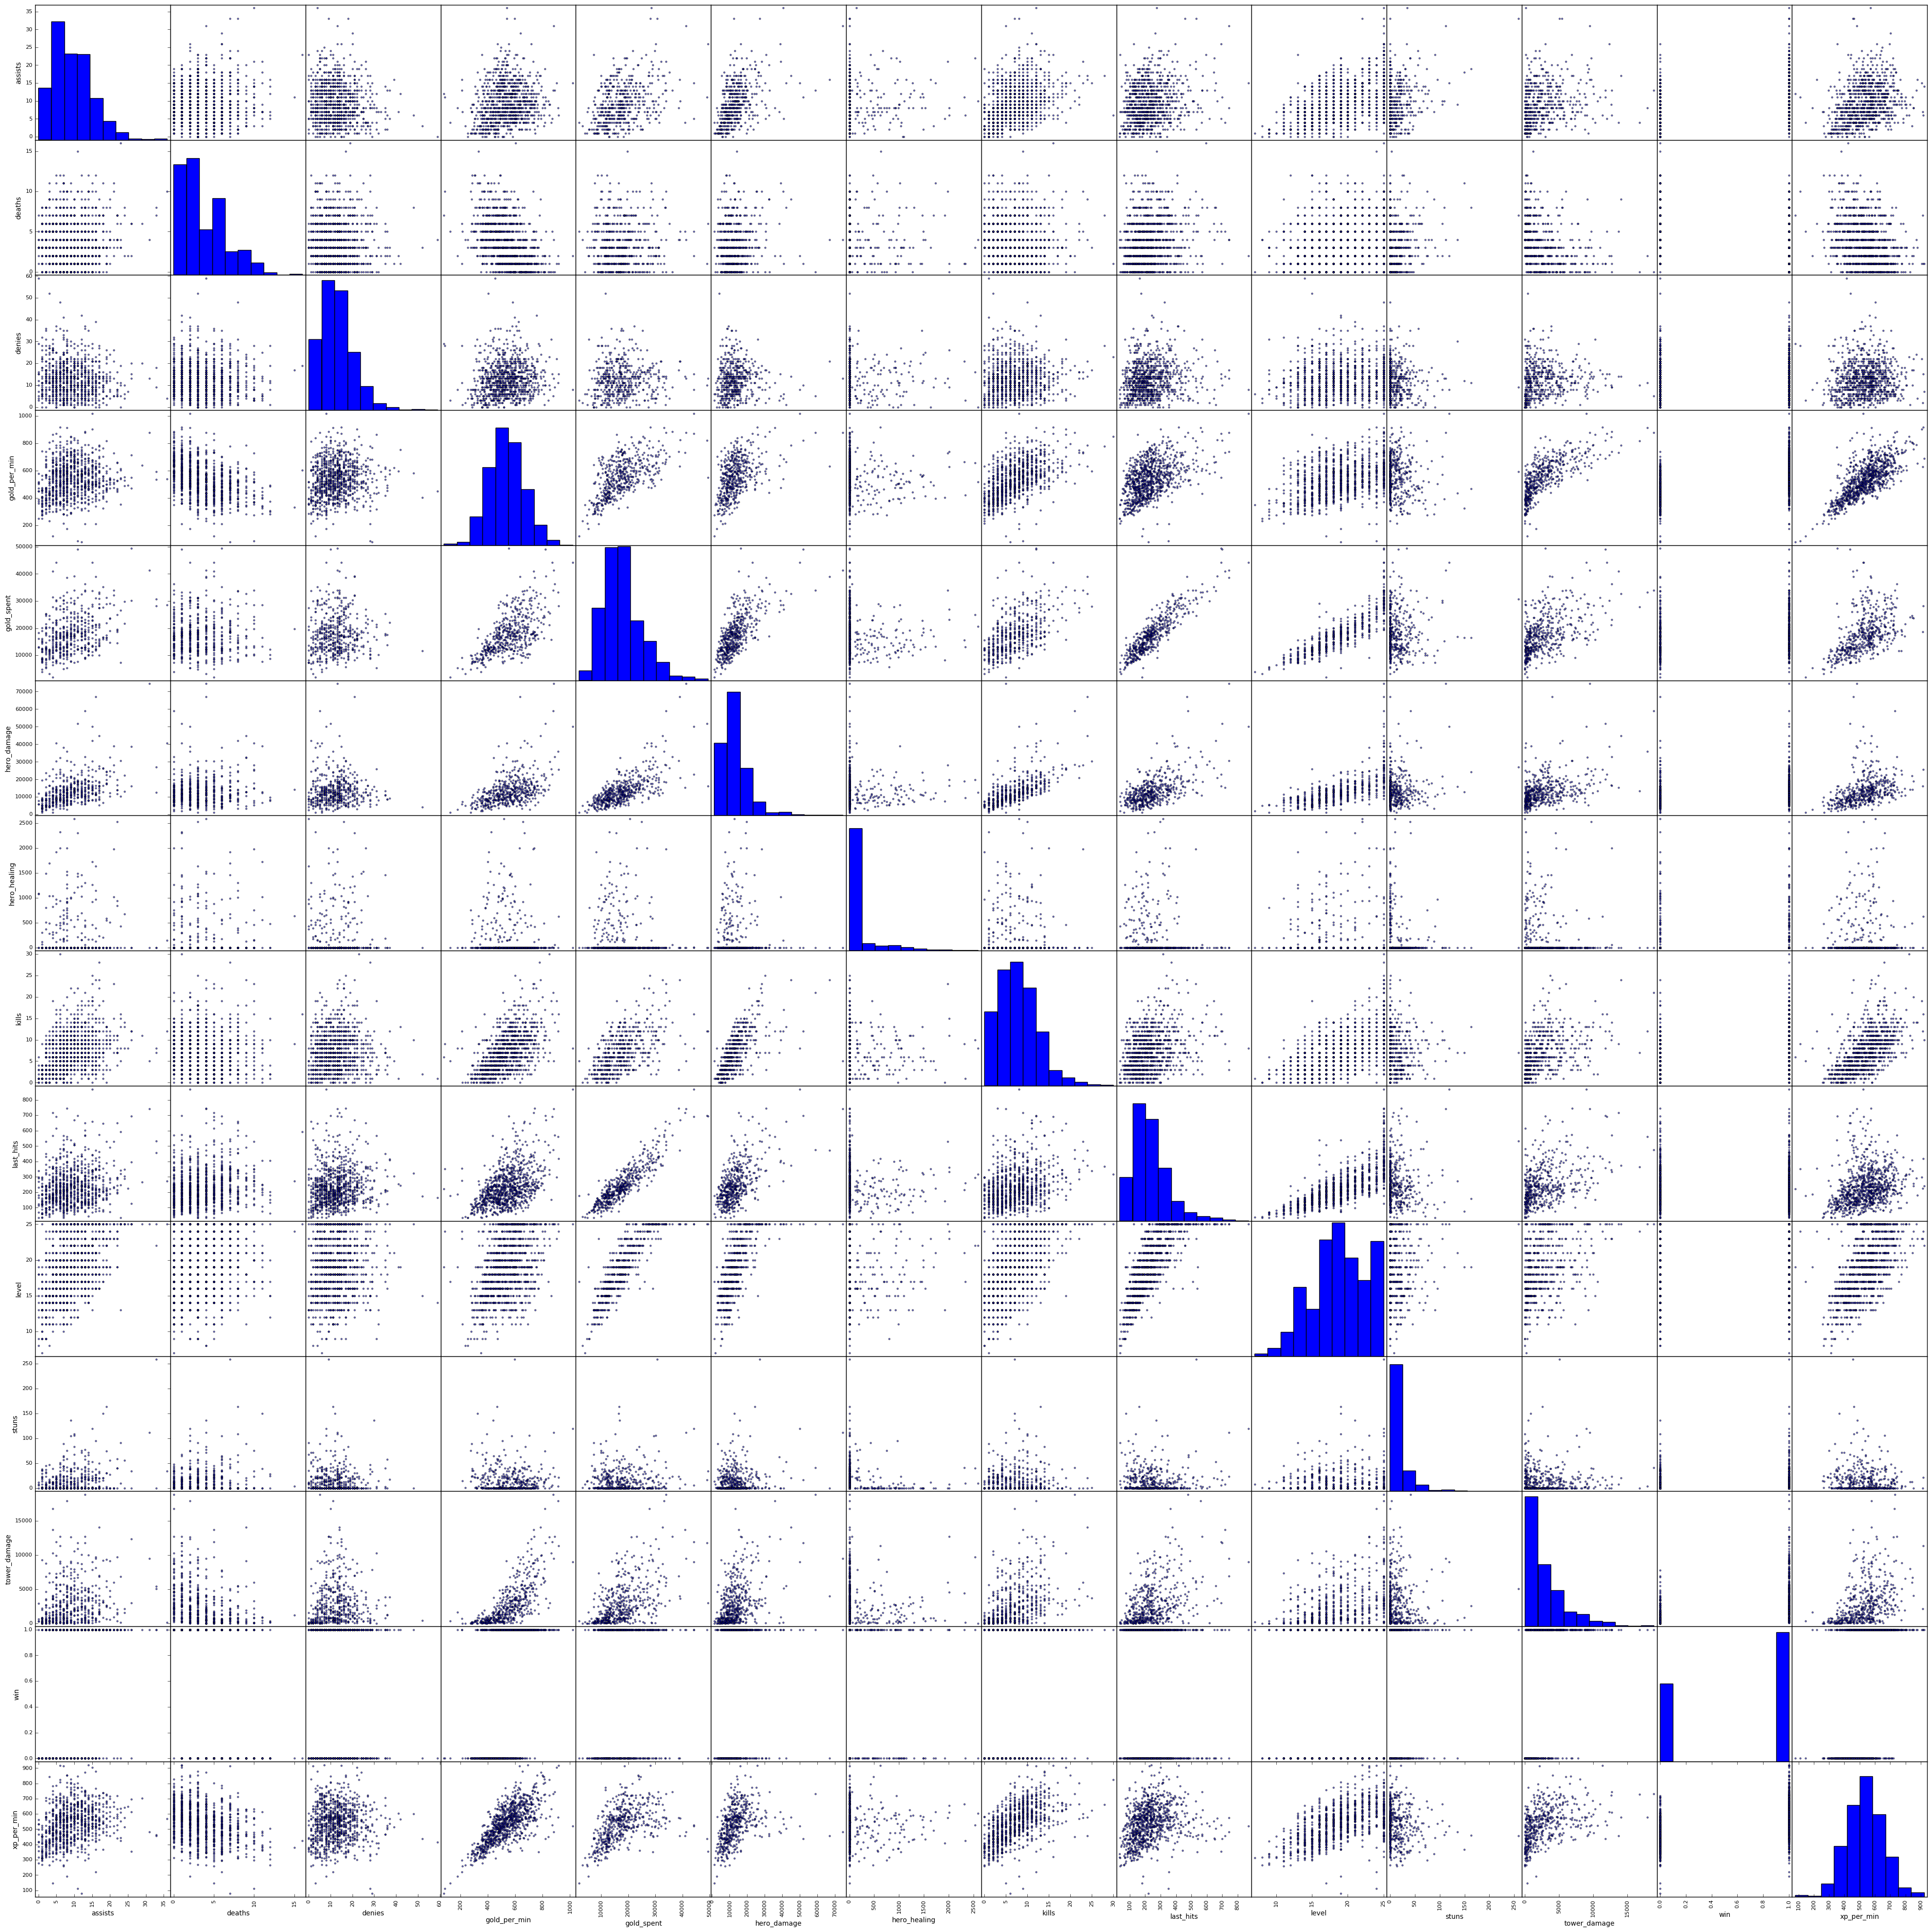

In [11]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df[numeric], alpha=0.5, figsize=(50, 50));

## Modify

In [12]:
df[numeric] = df[numeric].fillna(0)
df[numeric].describe()

assists      deaths      denies  gold_per_min    gold_spent  \
count  919.000000  919.000000  919.000000    919.000000    919.000000   
mean     9.401523    3.635473   12.732318    534.678999   9592.470076   
std      5.467157    2.794892    7.755253    129.479553  10409.762860   
min      0.000000    0.000000    0.000000     78.000000      0.000000   
25%      5.000000    1.000000    7.000000    446.000000      0.000000   
50%      9.000000    3.000000   12.000000    529.000000   8765.000000   
75%     13.000000    5.500000   17.000000    619.500000  17270.000000   
max     36.000000   16.000000   59.000000   1019.000000  49350.000000   

        hero_damage  hero_healing       kills   last_hits       level  \
count    919.000000    919.000000  919.000000  919.000000  919.000000   
mean    7301.335147     93.554951    7.280740  232.059848   18.809576   
std     9149.541143    323.818484    4.613796  118.281493    3.987682   
min        0.000000      0.000000    0.000000   34.000000    7.000000   
25%        0.000000      0.000000    4.000000  150.000000   16.000000   
50%     5205.000000      0.000000    7.000000  212.000000   19.000000   
75%    12529.000000      0.000000   10.000000  289.000000   22.000000   
max    74501.000000   2589.000000   30.000000  870.000000   25.000000   

            stuns  tower_damage  xp_per_min  
count  919.000000    919.000000  919.000000  
mean     7.825675   1578.077258  536.377584  
std     20.096745   2697.162457  120.040008  
min     -0.000024      0.000000   79.000000  
25%      0.000000      0.000000  453.500000  
50%      0.000000     91.000000  537.000000  
75%      4.443665   2235.000000  615.500000  
max    258.789000  18862.000000  922.000000

In [13]:
X = df.drop(ID, axis = 1)
X = X.drop(Target, axis = 1)
y = df[Target[0]] # Target[0] == 'win', Target instead of Target[0] causes problems at the learning step
feature_names = X.columns
print feature_names

Index([u'assists', u'deaths', u'denies', u'gold_per_min', u'gold_spent',
       u'hero_damage', u'hero_healing', u'kills', u'last_hits', u'level',
       u'stuns', u'tower_damage', u'xp_per_min'],
      dtype='object')


In [14]:
print X.shape
print y.shape
N, d = X.shape

(919, 13)
(919L,)


In [16]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print N_train, N_test

643 276


## Model

In [19]:
from sklearn import tree
from sklearn.grid_search import GridSearchCV

decTree = tree.DecisionTreeClassifier()
grid = GridSearchCV(decTree, param_grid={'max_depth': np.arange(5, 50)}, error_score=0)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_depth = grid.best_estimator_.max_depth
print best_cv_err, best_depth

0.149300155521 7


In [30]:
decTree = tree.DecisionTreeClassifier().set_params(max_depth = best_depth)
decTree.fit(X_train, y_train)
y_train_prediction = decTree.predict(X_train)
y_test_prediction = decTree.predict(X_test)

## Assessment

In [31]:
from sklearn import metrics
print 'Accuracy:\n', \
      'train: ', metrics.accuracy_score(y_train, y_train_prediction), \
      '\ntest: ',metrics.accuracy_score(y_test, y_test_prediction), '\n'
print 'Precision:\n', \
      'train: ', metrics.precision_score(y_train, y_train_prediction), \
      '\ntest: ',metrics.precision_score(y_test, y_test_prediction), '\n'
print 'Recall:\n', \
      'train: ', metrics.recall_score(y_train, y_train_prediction), \
      '\ntest: ',metrics.recall_score(y_test, y_test_prediction), '\n'
print 'AUCROC:\n', \
      'train: ', metrics.roc_auc_score(y_train, y_train_prediction), \
      '\ntest: ',metrics.roc_auc_score(y_test, y_test_prediction), '\n'

Accuracy:
train:  0.975116640747 
test:  0.855072463768 

Precision:
train:  0.970149253731 
test:  0.876344086022 

Recall:
train:  0.989847715736 
test:  0.905555555556 

AUCROC:
train:  0.970827472326 
test:  0.832986111111 



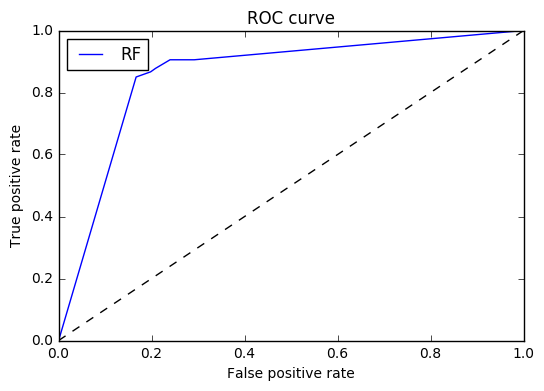

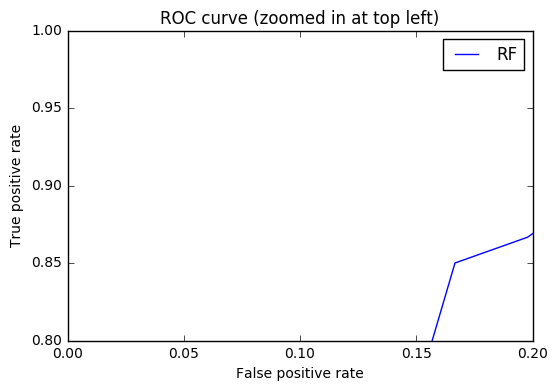

In [32]:
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
y_pred_rf = decTree.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

Confusion matrix, without normalization
[[ 73  23]
 [ 17 163]]


NameError: global name 'itertools' is not defined

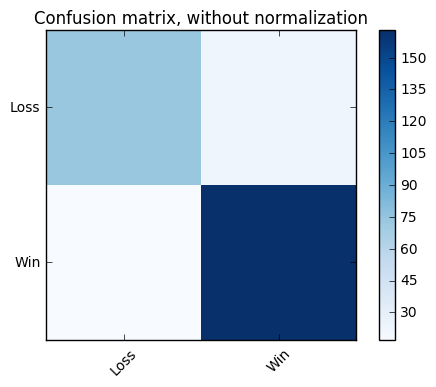

In [33]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Loss', 'Win'],
                      title='Confusion matrix, without normalization')


### Decision Tree Graph (См. приложение)

Результат записывается в файл, код из данного файла не хочет рисоваться в питоне, поэтому была использована онлайн платформа: 
http://dreampuf.github.io/GraphvizOnline/

Orange = False (Team Lost), Blue = True (Team Won)

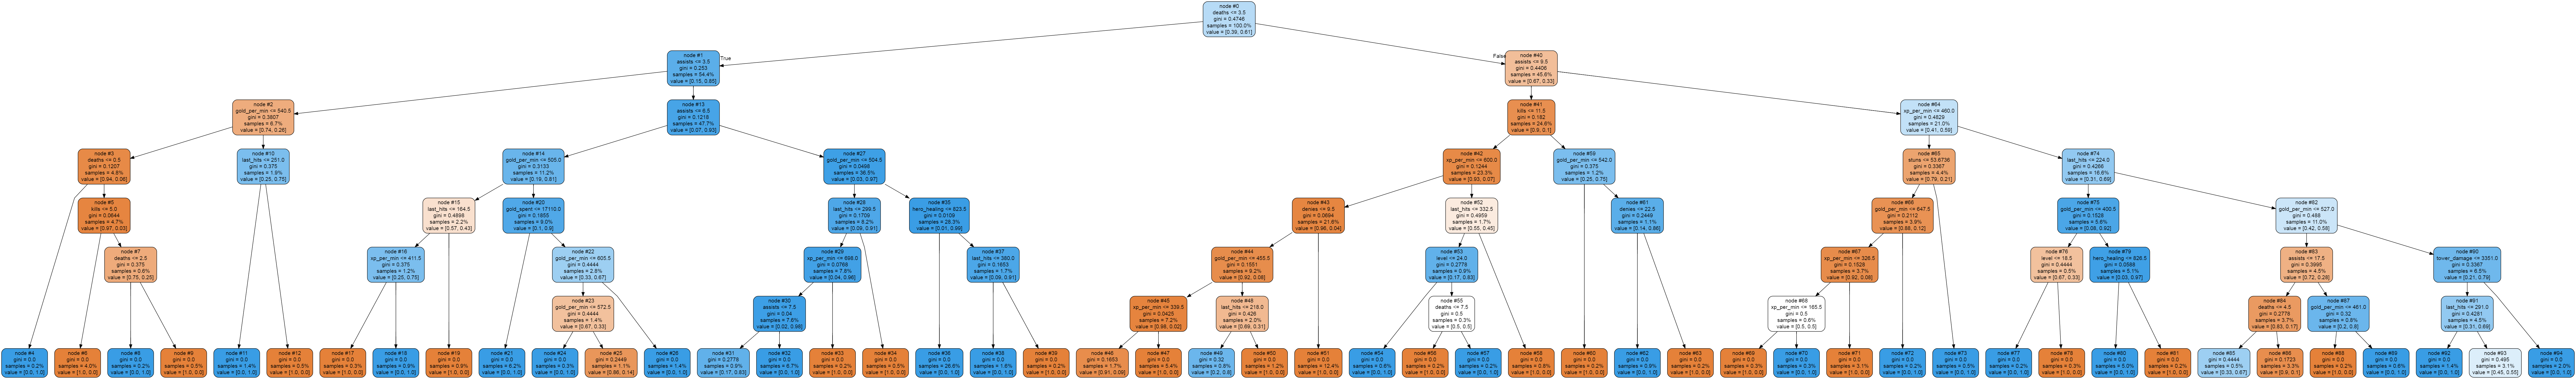

In [40]:
# !pip install pydotplus
from IPython.display import Image  
# import pydotplus

dot_data = tree.export_graphviz(decTree,
                                feature_names = X_train.columns.values, 
                                out_file='tree_all_matches.dot',
                                filled=True, 
                                rounded=True,
                                leaves_parallel = True,
                                impurity = True,
                                node_ids = True,
                                proportion = True,
                                
                               )
# graph = pydot.graph_from_dot_data(dot_data) 
# # Image(graph.create_png())
Image("tree_all_matches.png")

### Node Rules

Возвращает схему дерева решений в форме if-else условия

In [41]:
def get_code(tree, feature_names, target_names,
             spacer_base="    "):
    """Produce psuedo-code for decision tree.

    Args
    ----
    tree -- scikit-leant DescisionTree.
    feature_names -- list of feature names.
    target_names -- list of target (class) names.
    spacer_base -- used for spacing code (default: "    ").

    Notes
    -----
    based on http://stackoverflow.com/a/30104792.
    """
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth):
        spacer = spacer_base * depth
        if (threshold[node] != -2):
            print(spacer + "if ( " + features[node] + " <= " + \
                  str(threshold[node]) + " ) {")
            if left[node] != -1:
                    recurse(left, right, threshold, features,
                            left[node], depth+1)
            print(spacer + "}\n" + spacer +"else {")
            if right[node] != -1:
                    recurse(left, right, threshold, features,
                            right[node], depth+1)
            print(spacer + "}")
        else:
            target = value[node]
            for i, v in zip(np.nonzero(target)[1],
                            target[np.nonzero(target)]):
                target_name = target_names[i]
                target_count = int(v)
                print(spacer + "return " + str(target_name) + \
                      " ( " + str(target_count) + " examples )")

    recurse(left, right, threshold, features, 0, 0)

Схема:

In [42]:
get_code(decTree, X.columns.values, 'LW')

if ( deaths <= 3.5 ) {
    if ( assists <= 3.5 ) {
        if ( gold_per_min <= 540.5 ) {
            if ( deaths <= 0.5 ) {
                return W ( 1 examples )
            }
            else {
                if ( kills <= 5.0 ) {
                    return L ( 26 examples )
                }
                else {
                    if ( deaths <= 2.5 ) {
                        return W ( 1 examples )
                    }
                    else {
                        return L ( 3 examples )
                    }
                }
            }
        }
        else {
            if ( last_hits <= 251.0 ) {
                return W ( 9 examples )
            }
            else {
                return L ( 3 examples )
            }
        }
    }
    else {
        if ( assists <= 6.5 ) {
            if ( gold_per_min <= 505.0 ) {
                if ( last_hits <= 164.5 ) {
                    if ( xp_per_min <= 411.5 ) {
                        return L ( 2 examples )
 